# Examples for final report

## Imports

In [14]:
from contextlib import suppress
from itertools import product
from functools import partial, reduce
import pathlib
import numpy as np
import pandas as pd
import recordlinkage as rl

from scipy.optimize import bisect
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

from neighbourhood_blocking import NeighbourhoodBlockIndex

%matplotlib inline
sns.set_style('white')

## Settings

In [15]:
tradeoff_stats_file = pathlib.Path('../data/cache/experiments/tradeoff_stats_generated.pickle')
tradeoff_stats_file.parent.mkdir(parents=True, exist_ok=True)

## Example points

In [16]:
def sample_dataset_and_true_matches(n_base=500, n_perturbations=1, n_columns=5, null_proportion=0.01):
    np.random.seed(1)
    axis_names = ['dim_{}'.format(n) for n in range(1, n_columns+1)]
    def random_ordinates(random_func, scale=1):
        return pd.DataFrame(data=random_func(n_base, n_columns)*scale, columns=axis_names)
    base_points = random_ordinates(np.random.rand, 1)
    points = pd.concat([base_points] + [base_points + random_ordinates(np.random.randn, 0.01) for _ in range(n_perturbations)]
                       , ignore_index=True)
    points.index = ['point_{n}'.format(**locals()) for n in range(len(points))]
    true_matches = pd.MultiIndex.from_arrays(arrays=points.index.values.reshape(n_perturbations + 1,-1), names=['p1', 'p2'])
    def with_random_nulls(df, null_proportion, inplace=False):
        rows, cols = [a.flatten() for a in np.meshgrid(np.arange(len(df)), np.arange(len(df.columns)))]
        ndx_nulls = np.random.choice(np.arange(len(rows)), size=int(null_proportion*len(rows)), replace=False)
        result = df if inplace else df.copy()
        result.values[rows[ndx_nulls], cols[ndx_nulls]] = np.nan
        return result
    points = with_random_nulls(points, null_proportion=null_proportion, inplace=True)
    return points, true_matches
points, true_matches = sample_dataset_and_true_matches()

In [17]:
stats = pd.DataFrame()
indices = {}
full_index_size = rl.max_pairs(points)
stats.index.name = 'index_method'
def index_performance_stats(ndx):
    def normalized_index(ndx):
        ascending = ndx.get_level_values(0) < ndx.get_level_values(1)
        return ndx[ascending] | ndx.reorder_levels([1,0])[~ascending]
    norm_ndx = normalized_index(ndx)
    norm_true = normalized_index(true_matches)
    norm_common = norm_ndx & norm_true
    return {'recall': len(norm_common) / len(norm_true),
            'specificity': len(norm_common) / (len(norm_ndx) or 1),
            'reduction_ratio': 1 - (len(norm_ndx) / full_index_size)}
def record_index(label, index, index_type=None, axes=None):
    indices[label] = index
    stats.loc[label, 'pair_count'] = len(index)
    stats.loc[label, 'index_type'] = index_type or ''
    stats.loc[label, 'axes'] = str(axes or '')
    for k, v in sorted(index_performance_stats(index).items()):
        stats.loc[label, k] = v
all_pairs_label = 'All pairs'
record_index('True matches', true_matches, 'true')
record_index(all_pairs_label, rl.FullIndex().index(points), rl.FullIndex.__name__)

In [18]:
def plot_points(row_width=None, col_width=None, ax=None):
    if ax is None: ax = plt.gca()
    for col_name, lim_fun, div_width, line_fun in zip(points.columns, [ax.set_xlim, ax.set_ylim], [col_width, row_width], [ax.axvline, ax.axhline]):
        col = points[col_name]
        lo, hi = col.min(), col.max()
        lim_fun(lo, hi)
        if div_width:
            ordinates = np.arange(lo, hi, div_width)
            if len(ordinates) < 50:
                for ordinate in ordinates:
                    line_fun(ordinate, color='grey')
    if row_width or col_width:
        def block_status(axis_name, width):
            return np.floor((points[axis_name] - points[axis_name].min())/width) % 2 if (width>0) else 0
        highlighted = block_status(points.columns[0], col_width) == block_status(points.columns[1], row_width)
        sections = [points.loc[ndx, :] for ndx in [highlighted, ~highlighted]]
    else:
        sections = [points]
    for section in sections:
        sns.regplot(*list(points.columns)[:2], data=section, fit_reg=False, marker='.', ax=ax)

### Distance frequencies

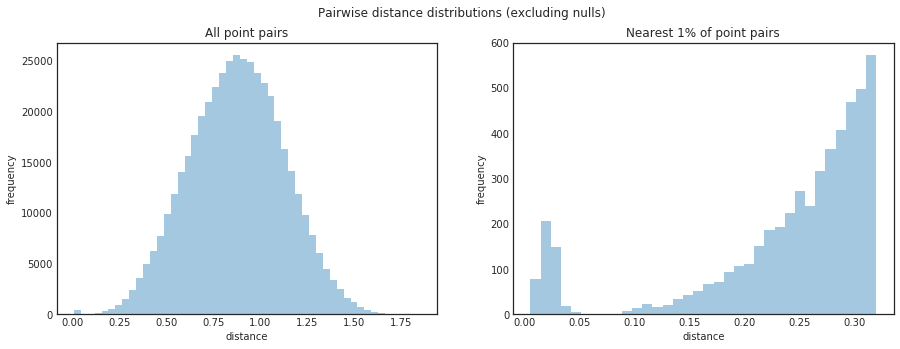

In [19]:
def distances_from_index(index):
    ordinates = points
    index_values = index.to_frame().values
    diffs = ordinates.loc[index_values[:,0],:].values - ordinates.loc[index_values[:,1],:].values
    return np.sqrt(np.sum(diffs * diffs, axis=1))
to_plot = distances_from_index(indices[all_pairs_label])
fig, axs = plt.subplots(figsize=(15,5), nrows=1, ncols=2)
detail_proportion = 0.01
for (title, dists), ax in zip([('All point pairs', to_plot), ('Nearest {:.0%} of point pairs'.format(detail_proportion), np.sort(to_plot)[:1+int(detail_proportion * len(to_plot))])], axs.flatten()):
    sns.distplot(dists[~np.isnan(dists)], ax=ax, kde=False)
    ax.set_title(title); ax.set_xlabel('distance'), ax.set_ylabel('frequency')
plt.suptitle('Pairwise distance distributions (excluding nulls)')
plt.show();

## Blocking comparison

In [20]:
def solved_index_param(index_getter, target_recall, x_min, x_max):
    def recall_error(x):
        return target_recall - index_performance_stats(index_getter(x))['recall']
    return bisect(recall_error, x_min, x_max)

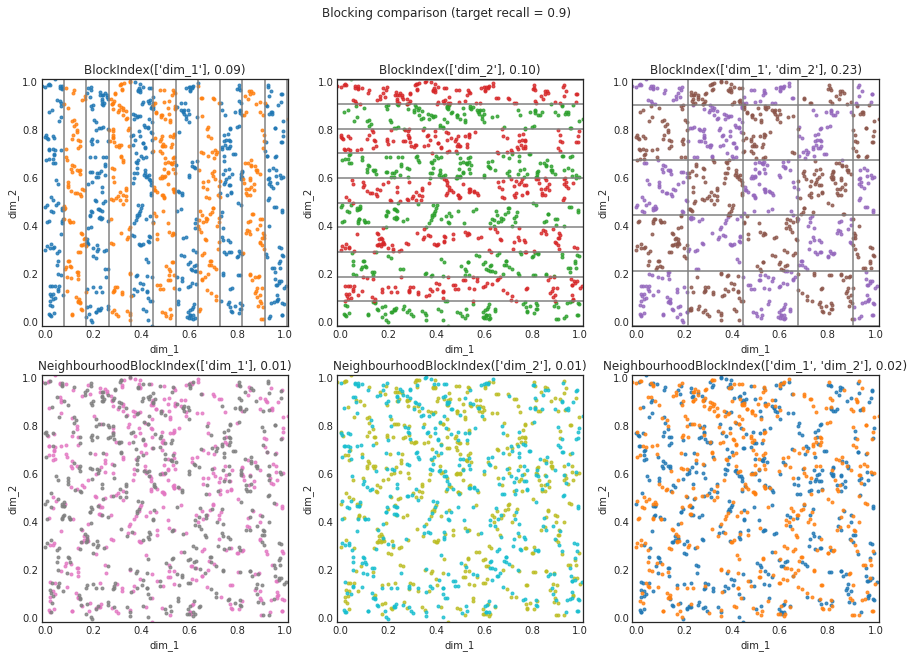

In [21]:
def block_index(index_type, axis_names, block_size, **kwargs):
    blocks = pd.DataFrame({axis_name: np.floor((points[axis_name] - points[axis_name].min()) / block_size)
                          for axis_name in axis_names})
    return index_type(on=list(blocks.columns), **kwargs).index(blocks)

def get_block_size(index_type, axis_names, target_recall, max_blocks=1000):
    max_size = points.max().max() - points.min().min()
    return solved_index_param(index_getter=partial(block_index, index_type, axis_names), target_recall=target_recall, x_min=max_size/max_blocks, x_max=max_size)

axis_names_2d = list(points.columns)[:2]
target_recall = 0.9
index_types = [rl.BlockIndex, NeighbourhoodBlockIndex]
fig, axs = plt.subplots(figsize=(15,5*len(index_types)), nrows=len(index_types), ncols=len(axis_names_2d)+1)
for (index_type, current_axis_names), ax in zip(product(index_types, [[nm] for nm in axis_names_2d] + [axis_names_2d]), axs.flatten()):
    ax.set_color_cycle(None)
    block_size = get_block_size(index_type=index_type, axis_names=current_axis_names, target_recall=target_recall)
    label = '{index_type.__name__}({current_axis_names}, {block_size:.2f})'.format(**locals())
    record_index(label, block_index(index_type=index_type, axis_names=current_axis_names, block_size=block_size), 
                 index_type.__name__, current_axis_names)
    plot_points(*list(reversed(list((block_size if nm in current_axis_names else 0) for nm in axis_names_2d))), ax=ax)
    ax.set_title(label)
plt.suptitle('Blocking comparison (target recall = {target_recall})'.format(**locals()))
plt.show();

## Sorted neighbourhood

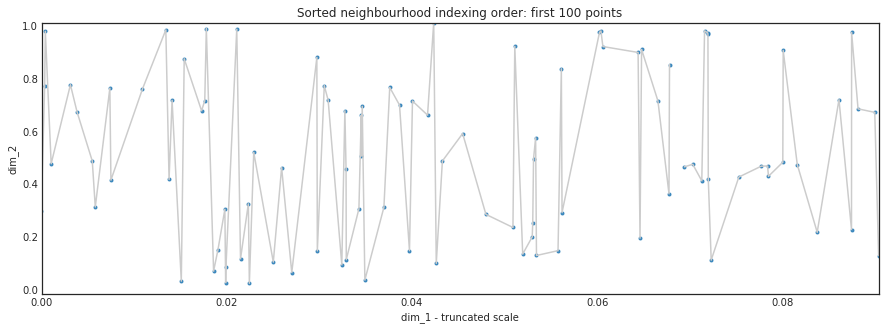

In [22]:
def smallest_integer_param(index_getter, min_recall, initial_guess=1, min_value=0, upward_sloping=True):
    bounds = [min_value, None]
    current_guess = initial_guess
    while (bounds[1] is None) or (bounds[1]-bounds[0] > 1):
        bounds[((index_performance_stats(index_getter(current_guess))['recall'] > min_recall) == upward_sloping) * 1] = current_guess
        current_guess = bounds[0] * 2 if bounds[1] is None else sum(bounds) // 2
    return bounds[upward_sloping * 1]

def sorted_neighbourhood_index(axis_name, window):
    return rl.SortedNeighbourhoodIndex(on=axis_name, window=window).index(points)

def get_sorted_neighbourhood_window(axis_name, min_recall=0.95, initial_guess=5):
    def window(half_window):
        return 1 + 2 * half_window
    half_window = smallest_integer_param(index_getter = (lambda half_window: sorted_neighbourhood_index(axis_name=axis_name, window=window(half_window))),
                                         min_recall = min_recall, initial_guess = max([1, initial_guess // 2]),
                                         upward_sloping=True)
    return window(half_window)

axis_name = points.columns[0]
window = get_sorted_neighbourhood_window(axis_name=axis_name, min_recall=target_recall)
record_index('SortedNeighbourhood({axis_name}, {window})'.format(**locals()), sorted_neighbourhood_index(axis_name, window), 
             rl.SortedNeighbourhoodIndex.__name__, [axis_name])
plt.figure(figsize=(15,5))
plot_points()
sorted_ordinates = points[points.columns[:2]].sort_values(axis_name).values
plt.plot(*sorted_ordinates.T, color='#cccccc')
n_points = 100
plt.gca().set_xlim(0, sorted_ordinates[n_points-1,0])
plt.title('Sorted neighbourhood indexing order: first {n_points} points'.format(**locals()))
plt.xlabel('{} - truncated scale'.format(axis_name))
plt.show();

## Statistics

In [23]:
pivoted_stats = stats.set_index(['index_type', 'axes']).unstack('axes')
pivoted_stats.style.format(lambda x: '' if pd.isnull(x) else (format(int(x), ',') if (x-int(x) == 0) else str(x)))

## Recall - reduction ratio tradeoff

In [24]:
from itertools import combinations, chain

def all_combinations(iterable, min_r=0, max_r=None):
    all_elems = list(iterable)
    return chain.from_iterable(combinations(all_elems, r) for r in range(max([int(min_r), 0]), min([len(all_elems), int(len(all_elems) if max_r is None else max_r)])+1))
def example_combinations(iterable, min_r=0, max_r=None):
    all_elems = list(iterable)
    return (all_elems[:r] for r in range(max([int(min_r), 0]), min([len(all_elems), int(len(all_elems) if max_r is None else max_r)])+1))

In [25]:
from operator import mul

def total_boundary_size(axis_discretization_intervals, points):
    axis_lengths = {col: (vals.max() - vals.min()) for col, vals in points.iteritems()}
    length_product = reduce(mul, axis_lengths.values(), 1)
    return sum(length_product / axis_lengths[axis] * int(axis_lengths[axis] / interval) 
               for axis, interval in axis_discretization_intervals.items()
               if interval)

In [ ]:
import datetime
start_time = datetime.datetime.now()
exhaustive = False
combinations_to_use = all_combinations if exhaustive else example_combinations
tradeoff_stats = pd.DataFrame()
ordinate_range = points.max().max() - points.min().min()
for n_blocks in [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.7, 2, 3, 4, 5, 7, 10, 15, 20, 30, 40, 50, 70, 100, 150, 200, 300, 400, 500, 700, 1000]:
#for n_blocks in [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]:
    print(n_blocks, end=' ')
    block_size = ordinate_range / n_blocks
    for index_desc, cols in product([#rl.FullIndex,
                                     rl.SortedNeighbourhoodIndex, 
                                     rl.BlockIndex, 
                                     NeighbourhoodBlockIndex, 
                                     (NeighbourhoodBlockIndex, {'max_nulls': 1}), 
                                     (NeighbourhoodBlockIndex, {'max_nulls': 2}),
                                    ], 
                                    combinations_to_use(points.columns, min_r=1)):
        index_type, index_kwargs = index_desc if isinstance(index_desc, tuple) else (index_desc, {})
        ndx_start_time = datetime.datetime.now()
        if index_type is rl.SortedNeighbourhoodIndex:
            if len(cols) > 1:
                continue
            param = 1 + 2*int(len(points) / n_blocks / 2)
            ndx = sorted_neighbourhood_index(axis_name=cols[0], window=param, **index_kwargs)
        elif index_type is rl.FullIndex:
            param = None
            ndx = index_type().index(points)
        else:
            param = block_size
            ndx = block_index(index_type=index_type, axis_names=cols, block_size=block_size, **index_kwargs)
        kwargs_repr = ', '.join([''] + ['{k}={v}'.format(**locals()) for k, v in sorted(index_kwargs.items())])
        label = '{index_type.__name__}({cols}, {param}{kwargs_repr})'.format(**locals())
        tradeoff_stats.loc[label, 'time'] = datetime.datetime.now() - ndx_start_time
        tradeoff_stats.loc[label, 'method'] = '{index_type.__name__} - {cols}{kwargs_repr}'.format(**locals())
        tradeoff_stats.loc[label, 'param'] = param
        tradeoff_stats.loc[label, 'n_pairs'] = len(ndx)
        tradeoff_stats.loc[label, 'dimensionality'] = len(cols)
        tradeoff_stats.loc[label, 'cls'] = index_type.__name__
        for k, v in index_kwargs.items():
            tradeoff_stats.loc[label, k] = v
        if index_type is rl.BlockIndex:
            tradeoff_stats.loc[label, 'total_boundary_size'] = total_boundary_size(axis_discretization_intervals={c: param for c in cols}, points=points)
        for k, v in index_performance_stats(ndx).items():
            tradeoff_stats.loc[label, k] = v
tradeoff_stats['dimensionality'] = tradeoff_stats['dimensionality'].astype(int)
print('elapsed: {}'.format(datetime.datetime.now() - start_time))

In [ ]:
tradeoff_stats.to_pickle(str(tradeoff_stats_file))

1


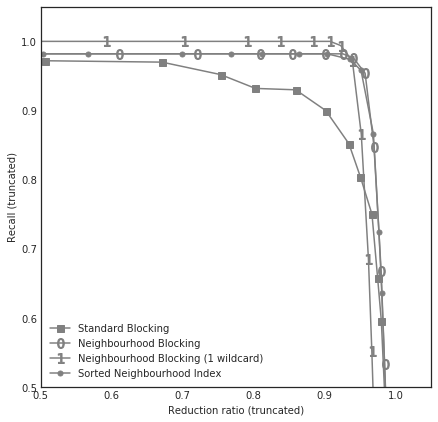

2


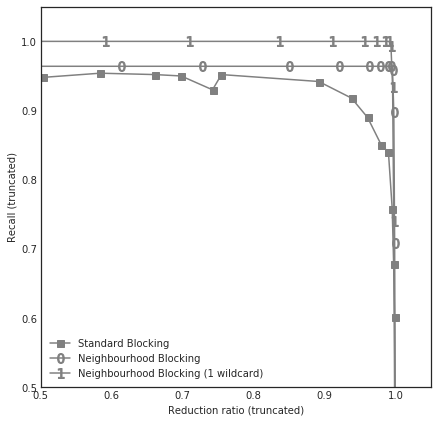

3


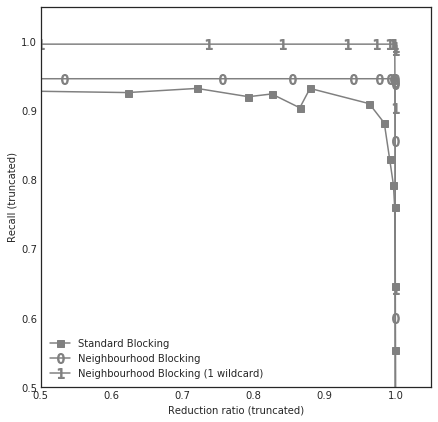

4


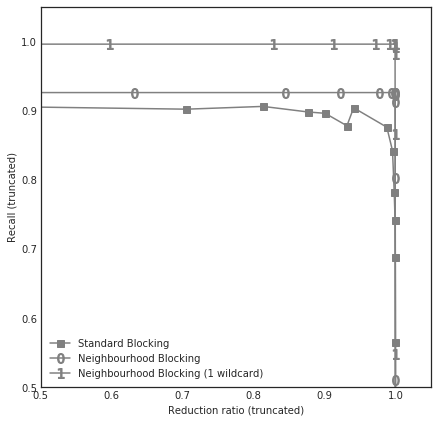

5


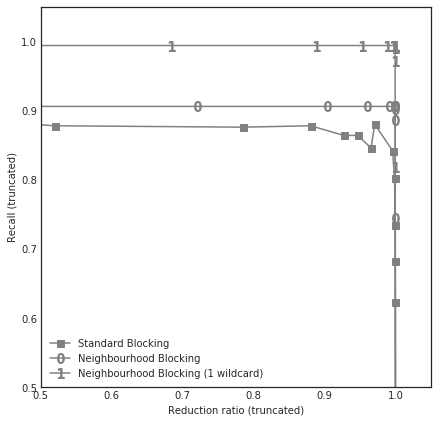

In [29]:
tradeoff_stats = pd.read_pickle(str(tradeoff_stats_file))
axis_vars = ['reduction_ratio', 'recall']
method_descriptions = {'BlockIndex': 'Standard Blocking',
                       'SortedNeighbourhoodIndex': 'Sorted Neighbourhood Index',
                       'NeighbourhoodBlockIndex': 'Neighbourhood Blocking',
                      }
markers = {('BlockIndex', None): ('s', 7),
           ('SortedNeighbourhoodIndex', None): ('o', 5),
           ('NeighbourhoodBlockIndex', None): ('$0$', 10),
           ('NeighbourhoodBlockIndex', 1): ('$1$', 10),
           ('NeighbourhoodBlockIndex', 2): ('$2$', 10),
           }

distinct_dimensionalities = sorted(tradeoff_stats['dimensionality'].unique())
for dimensionality, ax in zip(distinct_dimensionalities, axs.flatten()):
    plt.figure(figsize=(7,7))
    ax = plt.gca()
    stats_for_dimensionality = tradeoff_stats[tradeoff_stats['dimensionality'] == dimensionality]
    for mth in np.sort(stats_for_dimensionality['method'].unique()):
        sorted_points = tradeoff_stats[tradeoff_stats['method'] == mth].sort_values('param')
        cls_name = sorted_points['cls'].iloc[0]
        description = method_descriptions[cls_name]
        max_nulls = sorted_points['max_nulls'].iloc[0]
        if max_nulls > 1:#dimensionality:
            continue
        max_nulls_repr = '' if pd.isnull(max_nulls) else ' ({} wildcard{})'.format(int(max_nulls), '' if max_nulls == 1 else 's')
        label = '{description}{max_nulls_repr}'.format(**locals())
        marker, markersize = markers[(cls_name, None if pd.isnull(max_nulls) else int(max_nulls))]
        #linestyle='None'
        linestyle='-'
        ax.plot(*[sorted_points[col].values for col in axis_vars], color='grey', linestyle=linestyle, marker=marker, markersize=markersize, label=label)
    ax.legend(loc='lower left')
    ax.set_xlabel(axis_vars[0]); ax.set_ylabel(axis_vars[1])
    ax.set_ylim(0.5, 1.05)
    ax.set_xlim(0.5, 1.05)
    ax.set_xlabel('Reduction ratio (truncated)'); ax.set_ylabel('Recall (truncated)')
    #ax.set_title('{dimensionality} blocking key{s}'.format(s='' if dimensionality == 1 else 's', **locals()))
    print(dimensionality)
    plt.show()

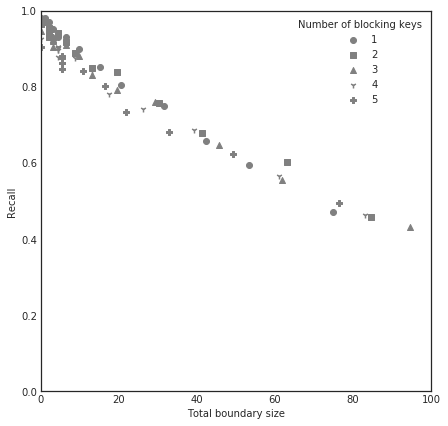

In [28]:
def plot_vs_total_boundary_size(stat_name, xlims=None, ylims=None):
    to_plot = tradeoff_stats[~tradeoff_stats['total_boundary_size'].isnull()]
    legend_title = 'Number of blocking keys'
    to_plot[legend_title] = to_plot['dimensionality']
    #sns.lmplot(x='total_boundary_size', y=stat_name, hue=legend_title, data=to_plot, fit_reg=False, size=5, legend_out=False)
    plt.figure(figsize=(7,7))
    ax = plt.gca()
    marker_types = np.array(['o', 's', '^', '1', 'P', '*'])
    for ndx, (marker, dimensionality) in enumerate(zip(marker_types, to_plot['dimensionality'].unique())):
        rows = to_plot['dimensionality'] == dimensionality
        ax.scatter(to_plot['total_boundary_size'][rows], to_plot[stat_name][rows], marker=marker, color='grey', label=str(dimensionality))
    plt.legend(title='Number of blocking keys')
    for lims, meth in [(xlims, ax.set_xlim), (ylims, ax.set_ylim)]:
        if lims:
            meth(*lims)
    #ax.set_title('Standard Blocking: {stat_name} vs total boundary size'.format(**locals()))
    ax.set_xlabel('Total boundary size'), ax.set_ylabel(stat_name.title())
    plt.show()
max_boundary_size = 100
plot_vs_total_boundary_size('recall', xlims=(0, max_boundary_size), ylims=(0, 1))

## OLS - recall vs boundary size

In [ ]:
dat = tradeoff_stats[tradeoff_stats['total_boundary_size'] <= max_boundary_size]
model = sm.OLS(dat['recall'].values, sm.add_constant(dat['total_boundary_size'].values)).fit()
print(model.summary())